# Interpolations

A "brief" note on interpolating SAMI3 outputs...


I will try to keep this farily brief, yet thorough enough to discuss everything relevant.
There is a large chance open questions will remain, please reach out with questions, comments, feedback, etc. 



## Summary

Many people use [`scipy.interpolate.griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) for interpolations, though I have not found it works well enough.
In 1- & 2-D, one can use a cubic interpolator, though 3D data requires the use of a linear interpolator. In the backend, this is specifically [`scipy.interpolate.LinearNDInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator). Farther into the backend, [Qhull](http://www.qhull.org/) is used to compute a Delaunay Triangulation, which is then used to generate & apply weights when output locations are specified.

Calculating the original Delaunay triangulation is slow. But LinearNDInterpolator can be sped up by pre-computing the triangulation (for example at every time-step) which can be stored in memory or read from a file. Doing this can save a decent amount of time, though is not perfect.

LinearNDInterpolator works by doing a linear interpolation in N-dimensions, it does not account for the general trends in data (exponential decrease in density with altitude, for example). I have found that it is also ***very*** sensitive to the distances between source and destination grid cells. <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

After trying A LOT of other options I have settled on ESMF being best for most applications. [The Earth System Modeling Framework](https://earthsystemmodeling.org/) is a framework for building coupled models for different systems. We only need the grid remapping features, specifically just the weight generation capabilities. I have found that the automatic regrid function is not robust enough, so I only use ESMF to generate the necessary weight file and then apply the weights myself.

We'll get into detail on all of this in a bit. First some setup...



In [1]:
# Load some required modules:
import sys, os, datetime
sys.path.append('../../') # Add the project home directory to the $PATH variable, not necessary usually.

from utility_programs.read_routines import SAMI
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from tqdm import tqdm

In [2]:
# Read in just [e-] as an example from a SAMI3 run:
sami_data, sami_times = SAMI.read_to_nparray(os.path.expanduser('~') + '/example_sami_run', 
                                             pd.Timestamp('2013-03-16'), 
                                             cols=['edens'])

In [3]:
# And make an output grid: (this will be the same throughout the notebook)
out_lons = np.arange(0,360,4) # 0-360 with 4º steps
out_lats = np.arange(-90, 90, 2) # -90-90 with 2º steps
out_alts = np.arange(100, 2100, 100) # 100-2000 (km) with 100 km steps

In [4]:
out_lon, out_lat, out_alt = np.meshgrid(out_lons, out_lats, out_alts)
out_shape = out_lon.shape
out_lon = out_lon.flatten()
out_lat = out_lat.flatten()
out_alt = out_alt.flatten()

In [5]:
out_shape, out_lons.shape, out_lon.shape

((90, 90, 20), (90,), (162000,))



## LinearNDInterpolator (griddata)

[`scipy.interpolate.LinearNDInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator) is the one of the most recommended packages for doing 3-D interpolations in Python. This is the backend for [`scipy.interpolate.griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) in 3D.

LinearNDInterpolator works by connecting adjacent points with triangles "such that no point is inside the circumcircle of any triangle". The backend to compute this [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) is Qhull.

Unfortunately LinearNDInterpolator is a very thin wrapper around Qhull, making it a little difficult to see what is going on behind the scenes. I'll try my best to show what is happening, the best results we can get from LinearNDInterpolator, and how fast/slow it can be.


We'll use the data we have already read in & the output grid to interpolate a few timesteps. Then I'll speed it up. Then I'll show why it's bad.

In [6]:
# make alt mask above 10,000 km
ma = np.where(sami_data['grid']['alt'] < 10000)

> By masking below 10,000 km we can significantly speed up the Delaunay triangulation calculation. Some notes on this:
> - If we are only interested in a single altitude, we can mask ~100 km above and below to reduce the number of poisingle_alt_mask the calculations.
> - It would follow that we can build a different Delaunay triangulation for each point in the output grid. We cannot. 
>    - Not only is it inefficient (taking a lot of time to calculate), but it is also really hard to only select the points surrounding a point on the SAMI3 grid. If we only use the N nearest points, N needs to be ~2,000 to fully surround all mid- and low-latitude points in the output grid due to the shape of the SAMI grid. 
>    - Further, for large N nearest points, the interpolator is less "accurate". So as we increase the value of N nearest points, the interpolation output approaches the values given by inteprolating on the whole grid.
> - To speed up interpolations more, we can only select points from ~ 200-10,000 km. This reduced the number of points even more (SAMI3 has a lot of low latitude & altitude grid cells), but this masking would depend on the altitude the user wants to plot.

### Default Scipy Interpolations

Note, this is the same for both `griddata` and `LinearNDInterpolator` since they operate on the same backend in 3-D.

In [7]:
# x, y, z for interpolator are lon, lat, alt
in_coords = np.array([sami_data['grid']['glon'][ma], sami_data['grid']['glat'][ma], sami_data['grid']['alt'][ma]]).T
out_coords = np.array([out_lon, out_lat, out_alt]).T

# And then just interpolate 5 time steps, starting at the 300th time:
#  If we started at the 0th (first) time, the [e-] would all be zero.

t_start = 300
t_steps = 5

# Store outputs in a (num_times, num_lons, num_lats, num_alts) array:
out_vals = np.empty([t_steps,*out_shape])

timer1 = [] # rudimentary way to track time for each of the 2 compute lines in the loop
timer2 = []

for t_step in tqdm(range(t_steps)):
    timer1.append(datetime.datetime.now())
    interpolator =  LinearNDInterpolator(in_coords, sami_data['data']['edens'][:,:,:, t_start + t_step][ma].T)
    timer1[-1] = datetime.datetime.now() - timer1[-1]
    
    timer2.append(datetime.datetime.now())
    out_vals[t_step] = interpolator(out_coords).reshape(out_shape)
    timer2[-1] = datetime.datetime.now() - timer2[-1]
    

100%|██████████| 5/5 [08:48<00:00, 105.72s/it]


In [8]:
print(f"Building the interpolator took, on average, {np.mean(timer1).total_seconds()} seconds\n"
      f"And using the interpolator took, on average {np.mean(timer2).total_seconds()} seconds." )

Building the interpolator took, on average, 70.093435 seconds
And using the interpolator took, on average 35.616405 seconds.


This is **SLOW**!!

Doing this for a full run, for all variables, would take an exorbitant amount of time. We need something better!

As the cell above shows though, most of the time is spent building the Delaunay triangulation. Luckily, we can pre-compute this and then re-use it for all time-steps (and variables).

> Since the Delaunay triangulation is the same for all SAMI3 runs with the same resolution, the Delaunay triangulation (interpolator) can be built one and then read from memory/file and be reused for all subsequent runs, time-steps, and/or data variables.

This should take the time required and reduce it by a factor of 3. Let's try the same code but move the Delaunay calculation to outside the for-loop:

### Speeding up Scipy Interpolations

In [9]:
# Store outputs in a (num_times, num_lons, num_lats, num_alts) array:
out_vals2 = np.empty([t_steps,*out_shape])

timer1 = [] # rudimentary way to track time for each of the 2 compute lines in the loop
timer2 = []

DT_t_start = datetime.datetime.now()
DT = Delaunay(in_coords)
DT_t_end = datetime.datetime.now() - DT_t_start


for t_step in tqdm(range(t_steps)):
    timer1.append(datetime.datetime.now())
    interpolator =  LinearNDInterpolator(DT, sami_data['data']['edens'][:,:,:, t_start + t_step][ma].T)
    timer1[-1] = datetime.datetime.now() - timer1[-1]
    
    timer2.append(datetime.datetime.now())
    out_vals2[t_step] = interpolator(out_coords).reshape(out_shape)
    timer2[-1] = datetime.datetime.now() - timer2[-1]
    

100%|██████████| 5/5 [00:48<00:00,  9.74s/it]


In [10]:
print(f"After spending {DT_t_end.total_seconds()} seconds calculating the Delaunay triangulation,\n"
      f"Building the interpolator took, on average, {np.mean(timer1).total_seconds()} seconds\n"
      f"And using the interpolator took, on average {np.mean(timer2).total_seconds()} seconds." )

After spending 68.424362 seconds calculating the Delaunay triangulation,
Building the interpolator took, on average, 0.394158 seconds
And using the interpolator took, on average 9.34128 seconds.


Lovely! This is significantly faster. Additionally, because subsequent runs of this same loop speed up, interpolating a longer run will show an even more significant speedup (because a lot of the necessary triangulation data is sitting in cache & not being pulled from random memory addresses).

### Comparing results

Just as a sanity check, let's make sure the two interpolators produced the same result.

First, a map of [e-] at a single altitude (from raw data), then the interpolated outputs from both above methods, then a plot of the difference.

In [11]:
alt_idx = 4
print(f'These plots are all at {out_alt[alt_idx]} km')

These plots are all at 500 km


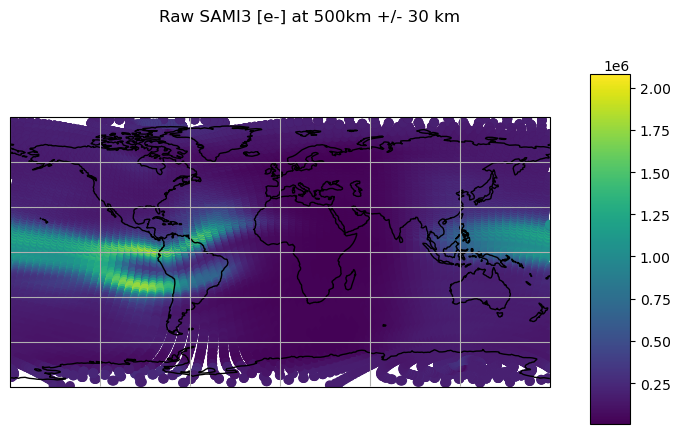

In [21]:
# PLOT A REFERENCE IMAGE:

min_alt = out_alt[alt_idx] - 30
max_alt = out_alt[alt_idx] + 30

single_alt_mask = np.where((sami_data['grid']['alt'] > min_alt) & (sami_data['grid']['alt'] < max_alt))

fig, axs = plt.subplots(1,1, figsize=(8,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
im0 = axs.scatter(sami_data['grid']['glon'][single_alt_mask], sami_data['grid']['glat'][single_alt_mask], 
            c=sami_data['data']['edens'][:,:,:, 305][single_alt_mask], transform=ccrs.PlateCarree())
axs.coastlines()
axs.gridlines()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im0, cax=cbar_ax)
fig.suptitle('Raw SAMI3 [e-] at 500km +/- 30 km')
fig.show();


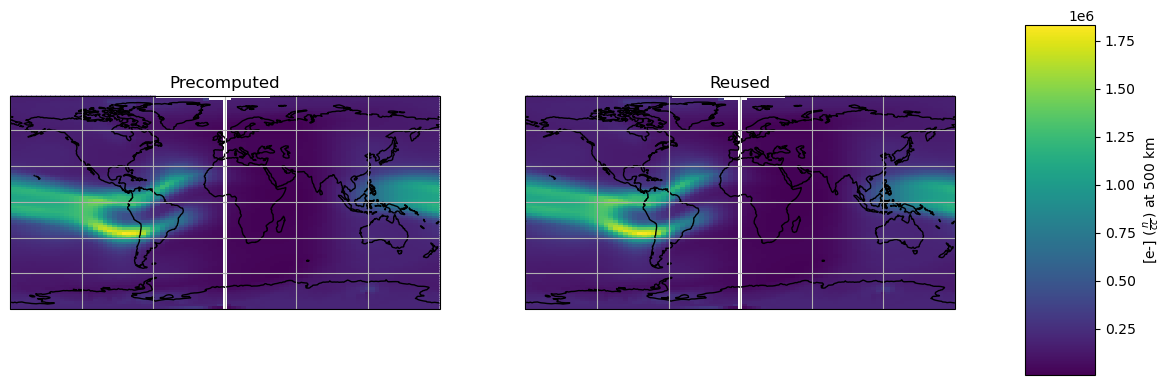

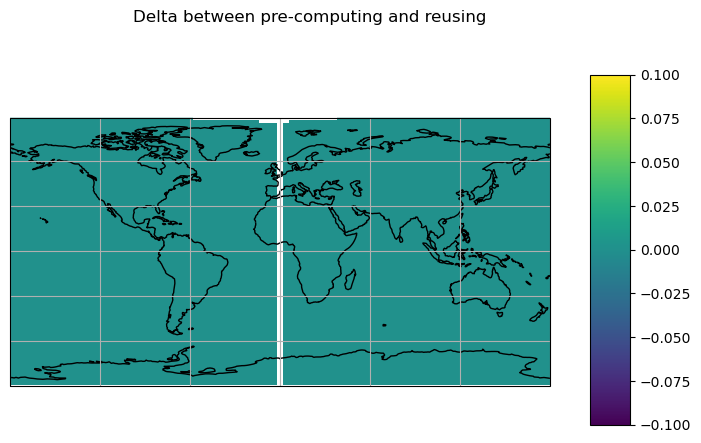

In [22]:
fig, axs = plt.subplots(1,2, width_ratios=(1,1),
                        figsize=(14,5), subplot_kw=dict(projection=ccrs.PlateCarree()))


axs[0].pcolor(out_lons, out_lats, out_vals[0,:,:,alt_idx])
axs[0].set_title('Precomputed')
im = axs[1].pcolor(out_lons, out_lats, out_vals2[0,:,:,alt_idx])
axs[1].set_title('Reused')
for ax in axs:
    ax.coastlines()
    ax.gridlines()
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='[e-] ($\\frac{n}{cc}$) at %i km' %out_alts[alt_idx])
fig.show();



fig, axs = plt.subplots(1,1, figsize=(8,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lons, out_lats, out_vals[0,:,:,alt_idx] - out_vals2[0,:,:,alt_idx])
axs.coastlines()
axs.gridlines()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
fig.suptitle('Delta between pre-computing and reusing')
fig.show();

So what is the problem with LinearNDInterpolator? It seems to be fast enough & the data looks good.

> The line at 0º longitude can be removed & shifted to 180º by adjusting the roll-over point in longitude, if desired.

There are a few reasons. Let's get into it!

### Problems with LinearNDInterpolator

1. It still isn't *that* fast. For 3 day SAMI3 run with outputs every 5 minutes, that would make ~850 output time steps. At ~5 seconds to interpolate each time step, that is ~4,200 seconds, or 70 minutes. Reasonable, but with more variables (SAMI outputs 15 densities, 4 temperatures, and 6 velocities), that's 25x70 = ***29 hours***. This can be multi-threaded but then we run into memory limitations. Sure, we don't need all that output data, but it is hard to predict what might be needed later, so it is nice to be able to just make it all.
1. It's not that accurate. I touched on this before, but will now show examples.
   1. In an ideal world, we can convert to cartesian coordinates (so the longitude is viewed as cyclic) and the gap disappears. But this just adds a ton of interpolation errors. Acutally, any sin/cos operations on the longitude/latitude result in these errors. not good! But I won't show it here.
   1. It seems that, no matter what kind of operations are done to the coordinates, interpolation errors show up along some axis. Let's take a look:


Here is a plot of the % difference between two timesteps, useful if one is looking for traveling features in the ionosphere:

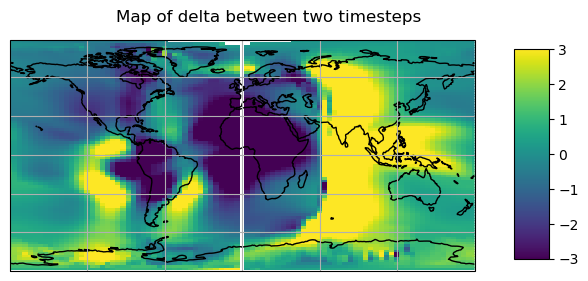

In [23]:
fig, axs = plt.subplots(1,1, figsize=(7,3), subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lons, out_lats, 100*(out_vals2[1,:,:,5] - out_vals2[0,:,:,5])/out_vals2[1,:,:,5], vmin=-3, vmax=3)
axs.coastlines()
axs.gridlines()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
fig.suptitle('Map of delta between two timesteps')
fig.show();

Looks normal!


Now if we plot a single geographic longitude (to see the altitude profile of a feature, for example):

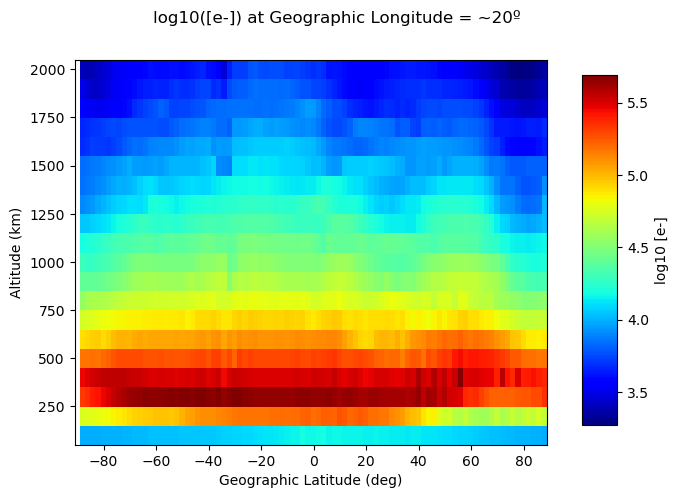

In [34]:
fig, axs = plt.subplots(1,1, figsize=(7,5))#, subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lats, out_alts, np.log10(out_vals2[1,5,:,:].T), cmap='jet')
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

Here is the raw data, for reference (taken within 2 degrees of longitude):

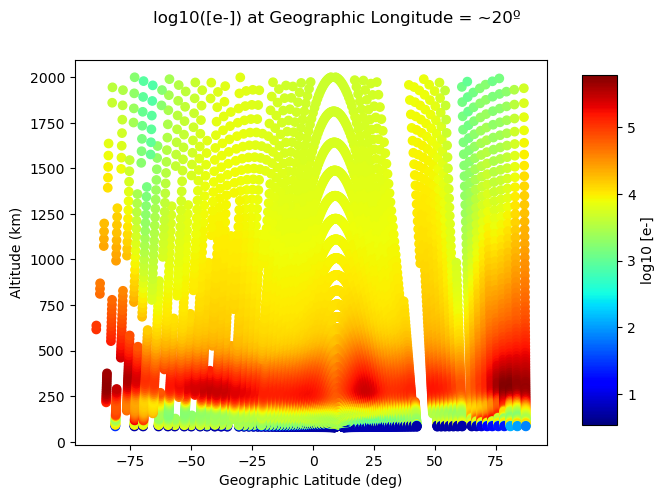

In [57]:
at_glon_ma = np.where((sami_data['grid']['glon'] > 18) & (sami_data['grid']['glon'] < 22) & (sami_data['grid']['alt'] < 2000))

fig, axs = plt.subplots(1,1, figsize=(7,5))
im2 = axs.scatter(sami_data['grid']['glat'][at_glon_ma], sami_data['grid']['alt'][at_glon_ma], 
                  c=np.log10(sami_data['data']['edens'][:,:,:,305][at_glon_ma]), cmap='jet')
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

Now if we narrow our mask from 2 to 1.5 degrees of longitude, one could maybe be convinced that the interpolation artifacts track fairly well with the distance from the cource grid... (It's sublte but I think that is causing the errors).

Source cells are in black & the background plot is the interpolated values:

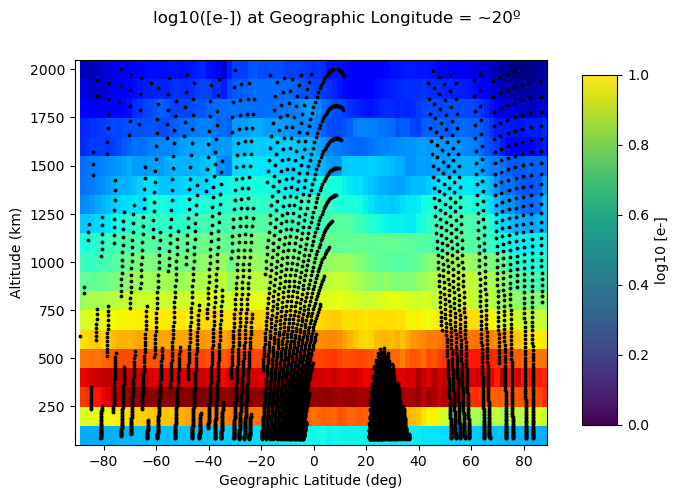

In [58]:
at_glon_ma = np.where((sami_data['grid']['glon'] > 18.5) & (sami_data['grid']['glon'] < 21.5) & (sami_data['grid']['alt'] < 2000))

fig, axs = plt.subplots(1,1, figsize=(7,5))
im2 = axs.pcolor(out_lats, out_alts, np.log10(out_vals2[1,5,:,:].T), cmap='jet')
im2 = axs.scatter(sami_data['grid']['glat'][at_glon_ma], sami_data['grid']['alt'][at_glon_ma], 
                  c='k', s=3)
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

This is only plotted at a coarse resolution to speed the notebook up. At higher resolutions (more altitude steps), the discontinuities get worse.

This plot is made during a geomagnetic quiet time so there should not be that many "ripples"/"discontinuities"/"peaks"/etc. Whatever you want to call them, they are not physical. They're just interpolation artifacts.

To *even* look more closely, here are a couple more plots. The values themselves are not important, we are just looking at how some cells are different than their neighbors:

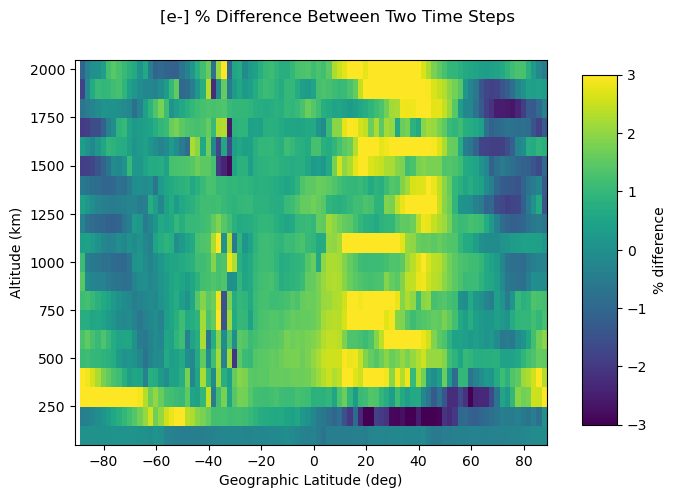

In [59]:
fig, axs = plt.subplots(1,1, figsize=(7,5))#, subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lats, out_alts, (100*(out_vals2[1,5,:,:] - out_vals2[0,5,:,:])/out_vals2[1,5,:,:]).T, vmin=-3, vmax=3)
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='% difference')
fig.suptitle('[e-] % Difference Between Two Time Steps')
fig.show();

Or across more time-steps:

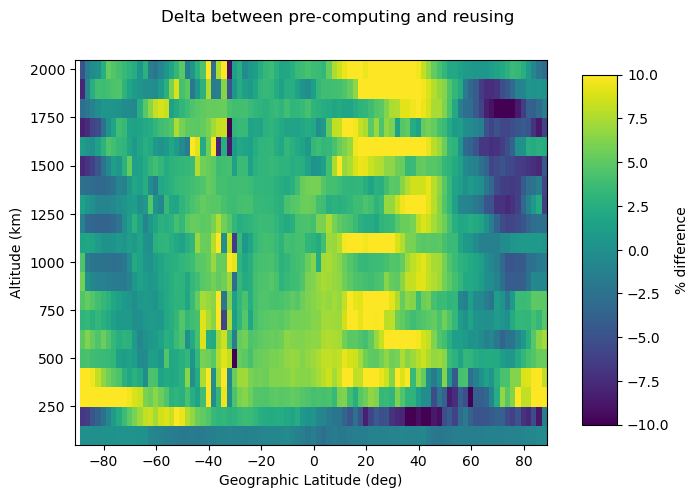

In [60]:
fig, axs = plt.subplots(1,1, figsize=(7,5))#, subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lats, out_alts, (100*(out_vals2[4,5,:,:] - out_vals2[0,5,:,:])/out_vals2[4,5,:,:]).T, vmin=-10, vmax=10)
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='% difference')
fig.suptitle('Delta between pre-computing and reusing')
fig.show();

Yeah, some of this is from the Terminator. But not all of it. 

There are interpolation artifacts that are present along the Altitude axis. At higher resolutions it is more apparent, though this can be left as a exercise to the user or something.


We need something that is more accurate in the interpolations. And ideally faster...


## ESMF

As previously mentioned, ESMF is **HUGE**. We only care about a small portion of its capabilities.

An interested reader can explore [ESMF's documentation here](https://earthsystemmodeling.org/doc/), but I'll highlight the important bits here for those who value their time and sanity.


- ESMF has several representations of different types of model output.
  - The different grid structures are a "grid" (regtangular), "Mesh" (unstructured), and LocStream (unstructured, not connected). We want to use a "mesh"
  - Coordinate systems can be Cartesian or Spherical. We want 3D Spherical.
- We feed the output of SAMI3 into ESMF, specify the output locations, and ESMF tells us the "Weights" required to map between the coordinates
  - Due to the nature of the SAMI3 cell location, we need a "Mesh", and to tell ESMF how the points are connected in space.
     - In a Mesh, one must specify the interconnects between "Nodes", or grid cells.
     - For SAMI3, the "Nodes" are the individual grid cells.
     - The interconnects between the nodes are specified by the longitudes, field lines, and point (or more formally, (nl, nf, nz)). We tell ESMF which node indices are connected.
     - For the output grid, this can either be a grid in geographic coordinates (with fixed or stretched altitudes), or a set out unconnected points (satellite trajectory).
  - ESMF will then look at the source & destination "Fields" and figure out how much to multiply each source point by to get the interpolated value at each destination point.
  - These "Weights" are written to file & we later apply those weights to whatever we want.
   - Because of the source & destination types and the coordinate system, not all ESMF interpolation methods & versions will work. See the [ESMF regridding status](https://earthsystemmodeling.org/regrid/) page for more details.
- ESMF uses a "Bilinear" interpolation scheme to calculate the weight matrix. I have not noticed the same issues in these interpolations as those in LinearNDInterpolator.
- ESMF is complicated. To simplify things, I call ESMF from the command line within python ("Offline regridding") rather than using the C/Fortran/Python implementations. It's easier this way, trust me. 

For more details, see the ESMF documentation through either of the above links. 

For now, I will just jump in & demonstrate how it is implemented in this repository and explain what I can...



### The Details

As previously mentioned, SAMI3 needs to be represented as a "Mesh" in ESMF. The `esmpy` package is really hard to debug. So we will be writing the source and destination coordinates to NetCDF files and then calling ESMF from the "command line" (through python) on those files.

#### Node Information

To get ESMF to see our source points correctly, we need to specify the node coordinates & indices and the interconnects between these nodes. The rest is commentary, as they say.


From the [ESMF docs](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/node5.html#SECTION050101100000000000000), this is the representation for a hexahedron (cube/cuboid). We need to arrange SAMI3 points to be in this shape, with these interconnects between nodes.

              8---------------7
             /|              /|
            / |             / |
           /  |            /  |
          /   |           /   |
         5---------------6    |
         |    |          |    |
         |    4----------|----3
         |   /           |   /
         |  /            |  /
         | /             | /        
         |/              |/
         1---------------2

         ESMF_MESHELEMTYPE_HEX 

From the perspective of point 1 in the cube above I have arranged the mesh as follows:
- Point 4 lies on the same longitude & field line (*nl*, *nf*), but  *nz + 1*
- Points 2 & 3 lie on the next magnetic longitude (*nl + 1*), though same *nf*
- Point 5 has the same *nl* and *nz* as point 1, but *nf + 1*

Magnetic north will point from point 1 -> 4, east is from point 1 -> 2, and "up" is from point 1 -> 5.

The points on this cube look as follows:

| Point number  |  nl  |  nf  | nz  |
|  ---   |  --- | ---  | --- |
| 1 | `nl` | `nf` | `nz`|
| 2 | `nl+1` | `nf` | `nz`|
| 3 | `nl+1` | `nf+1` | `nz`|
| 4 | `nl` | `nf+1` | `nz`|
| 5 | `nl` | `nf` | `nz+1`|
| 6 | `nl+1` | `nf` | `nz+1`|
| 7 | `nl+1` | `nf+1` | `nz+1`|
| 8 | `nl` | `nf+1` | `nz+1`|

At high magnetic latitudes where SAMI3 does not model, the invalid points are not included. At the longitude boundary we wrap to form a complete sphere. At the ends of field lines (where `nz+1` does not exist), the invalid points are also not included.

> This methodology is how the source mesh is created. If the user requests to output to a grid, a similar methodology is followed. In the case that a user provides 

We tell ESMF the point locations & the connection that each node has with its neighbors.





#### Writing Source & Destination Files

In order for ESMF to read various files, NetCDF conventions are strictly enforced. There are only a handful of file formats that ESMF does understand. Of these, some do not support 3D unstructured meshes and others are just not right for this use case. So we write the source and destination grids to UGRID format.

[More details are available here], though the relevant NetCDF header is printed below (copied from that link). This is a sample header, though shows the important information.

```
netcdf wam_ugrid100_110 {
dimensions:
	nnodes = 78432 ;
	ncells = 66030 ;
	eight = 8 ;
variables:
	int mesh ;
		mesh:cf_role = "mesh_topology" ;
		mesh:topology_dimension = 3. ;
		mesh:node_coordinates = "nodelon nodelat height" ;
		mesh:volume_node_connectivity = "vertids" ;
		mesh:volume_shape_type = "meshtype" ;
	double nodelon(nnodes) ;
		nodelon:standard_name = "longitude" ;
		nodelon:units = "degrees_east" ;
	double nodelat(nnodes) ;
		nodelat:standard_name = "latitude" ;
		nodelat:units = "degrees_north" ;
	double height(nnodes) ;
		height:standard_name = "elevation" ;
		height:units = "kilometers" ;
	int vertids(ncells, eight) ;
		vertids:cf_role = "volume_node_connectivity" ;
		vertids:start_index = 1. ;
	int meshtype(ncells) ;
		meshtype:cf_role = "volume_shape_type" ;
		meshtype:flag_range = 1. ;
		meshtype:flag_values = 1. ;
		meshtype:flag_meanings = "hexahedron" ;
}
```


#### Applying Weights

After the weight generation is run, a file is created with the weight information. The relevant information is `n_s` (number of source points), `row` (position in destination grid of a point, `i`), `S` (weight for each entry in the regridding matrix), and `col` (position in the destination grid). 

The formula to apply the weights is as follows:

``` Fortran

 ! Initialize destination field to 0.0
 do i=1, n_b
   dst_field(i)=0.0
 enddo

 ! Apply weights
 do i=1, n_s
   dst_field(row(i))=dst_field(row(i))+S(i)*src_field(col(i))
 enddo

``` 

For loops are slow in Python. I have implemented something vctorized that accomplishes this. See the source code (`apply_weight_file()`) for more details.


[More information on the Weight file is in the ESMF documentation linked here.](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/node3.html#SECTION03029000000000000000)


## ESMF vs LinearNDInterpolator

Don't worry. I handled all of the hard stuff with ESMF. There are a collection of functions in the `SAMI3_ESMF_Regrid.py` file.

Let's see how ESMF speed and accuracy compares to LinearNDInterpolator (on the same data).



In [ ]:
import SAMI3_ESMF_Regrid

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Not sure why this is. If I had to guess, it would be because SAMI3 does not always convert from magnetic to geographic coordinates perfectly. For years after 2010, IGRF coefficients from 2010 are used since SAMI3 uses an old IGRF/APEX coordinate model. There could also be floating point precision or rounding errors in Qhull/LinearNDInterpolator. 
